In [1]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches # For bounding boxes

from PIL import Image

from collections import defaultdict
import json

plt.rcParams['figure.figsize'] = (15, 15)

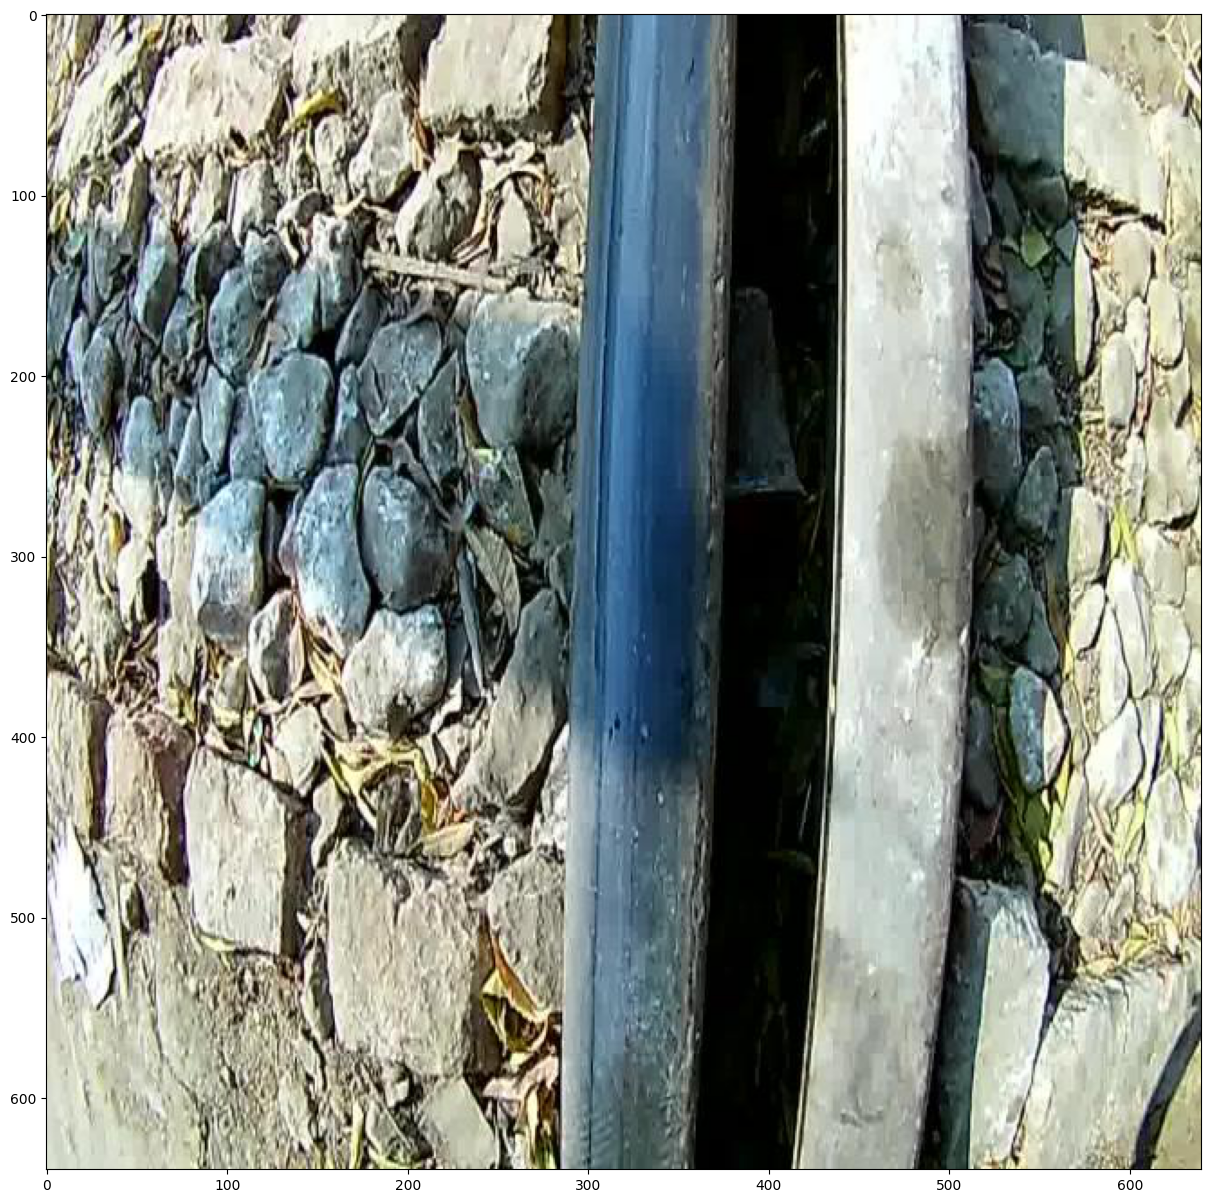

In [2]:
image_name = r"C:\Users\shiva\Desktop\EXCEED\Railway-Track-3\train\1-MOV_20201221091849_0245_JPEG.rf.c3df0144b0ee3e21e323f6f71c309d4a.jpg"

img = Image.open(image_name)
fig, ax = plt.subplots()
ax.imshow(img)
plt.show()

In [3]:
image_ids_annotations = defaultdict(list)

# Load annotations
path = r'C:\Users\shiva\Desktop\EXCEED\Railway-Track-3\train\_annotations.coco.json'
file = open(path)
anns = json.load(file)

# Add into datastructure
for ann in anns['annotations']:
    image_id = ann['image_id'] # Are integers
    image_ids_annotations[image_id].append(ann)

In [4]:
# Get mapping category_id to category name
catergory_id_to_name = dict()
for ann in anns['categories']:
    catergory_id_to_name[ann['id']] = ann['name']

DEBUG:__main__:Loaded 862 images
DEBUG:__main__:Loaded 664 image annotations
DEBUG:__main__:Processing image ID: 221
DEBUG:__main__:Found 1 annotations for image
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\shiva\\anaconda3\\envs\\GPU\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\shiva\\anaconda3\\envs\\GPU\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\shiva\\anaconda3\\envs\\GPU\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\

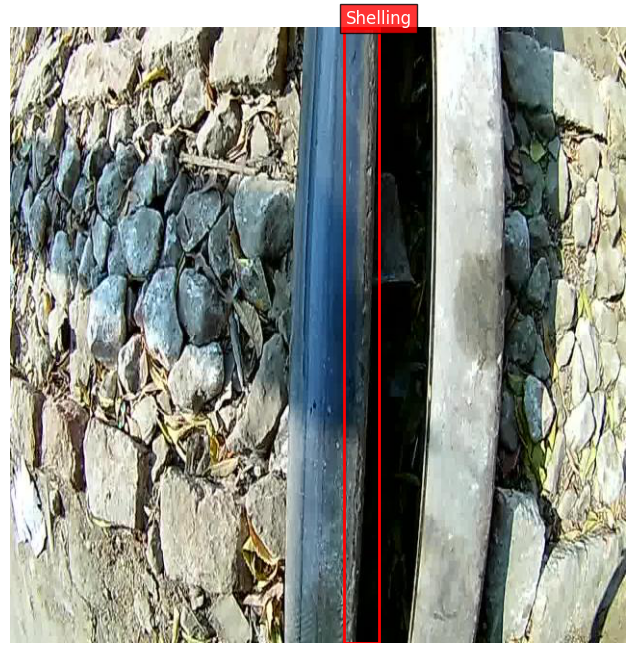

In [5]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import logging

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

def load_coco_annotations(json_path):
    """Load and verify COCO format annotations"""
    with open(json_path, 'r') as f:
        coco_data = json.load(f)
    
    # Create category mapping
    category_id_to_name = {
        cat['id']: cat['name'] 
        for cat in coco_data['categories']
    }
    
    # Create filename to image ID mapping
    filename_to_id = {
        img['file_name']: img['id']
        for img in coco_data['images']
    }
    
    # Create image ID to annotations mapping
    image_ids_annotations = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in image_ids_annotations:
            image_ids_annotations[img_id] = []
        image_ids_annotations[img_id].append(ann)
    
    logger.debug(f"Loaded {len(filename_to_id)} images")
    logger.debug(f"Loaded {len(image_ids_annotations)} image annotations")
    
    return category_id_to_name, image_ids_annotations, filename_to_id

def visualize_annotations(image_path, image_ids_annotations, category_id_to_name, filename_to_id):
    """Visualize image with correct bounding boxes"""
    try:
        filename = os.path.basename(image_path)
        
        # Get correct image ID from filename mapping
        if filename not in filename_to_id:
            logger.error(f"Image {filename} not found in annotations")
            return
            
        image_id = filename_to_id[filename]
        logger.debug(f"Processing image ID: {image_id}")
        
        img = Image.open(image_path)
        fig, ax = plt.subplots(figsize=(12, 8))
        
        if image_id in image_ids_annotations:
            annotations = image_ids_annotations[image_id]
            logger.debug(f"Found {len(annotations)} annotations for image")
            
            for ann in annotations:
                bbox = ann['bbox']
                category_name = category_id_to_name[ann['category_id']]
                
                x, y, w, h = [float(coord) for coord in bbox]
                rect = patches.Rectangle(
                    (x, y), w, h,
                    linewidth=2,
                    edgecolor='red',
                    facecolor='none'
                )
                ax.add_patch(rect)
                ax.text(
                    x+1, y-5,
                    category_name,
                    fontsize=12,
                    color='white',
                    bbox=dict(facecolor='red', alpha=0.8)
                )
        else:
            logger.warning(f"No annotations found for image ID {image_id}")
        
        ax.axis('off')
        ax.imshow(img)
        plt.show()
        
    except Exception as e:
        logger.error(f"Error visualizing image: {e}")

if __name__ == "__main__":
    json_path = r"C:\Users\shiva\Desktop\EXCEED\Railway-Track-3\train\_annotations.coco.json"
    image_path = r"C:\Users\shiva\Desktop\EXCEED\Railway-Track-3\train\1-MOV_20201221091849_0245_JPEG.rf.c3df0144b0ee3e21e323f6f71c309d4a.jpg"
    
    category_id_to_name, image_ids_annotations, filename_to_id = load_coco_annotations(json_path)
    visualize_annotations(image_path, image_ids_annotations, category_id_to_name, filename_to_id)

In [6]:
import os
import json
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [7]:
import os
import json
from collections import defaultdict

base_dir = r'C:\Users\shiva\Desktop\EXCEED\Railway-Track-3'

annotations = defaultdict(dict)
for split in ['test', 'train', 'valid']:
    with open(os.path.join(base_dir, split, '_annotations.coco.json'), 'r') as f:
        annotations[split] = json.load(f)

In [8]:
import os
import json
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
from tqdm import tqdm

In [9]:
class RailwayTrackDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        
        # Load annotations
        ann_file = os.path.join(root_dir, split, '_annotations.coco.json')
        with open(ann_file, 'r') as f:
            self.coco = json.load(f)
            
        # Create category mapping
        self.categories = {cat['id']: cat['name'] for cat in self.coco['categories']}
        
        # Create image to annotations mapping
        self.img_to_anns = self._load_annotations()
        
        # Create image list for easy indexing
        self.image_ids = [img['id'] for img in self.coco['images']]
        
        # Setup transforms
        self.transform = transform or T.Compose([
            T.Resize((640, 640)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _load_annotations(self):
        img_to_anns = {}
        for ann in self.coco['annotations']:
            img_id = ann['image_id']
            if img_id not in img_to_anns:
                img_to_anns[img_id] = []
            img_to_anns[img_id].append(ann)
        return img_to_anns
        
    def __len__(self):
        return len(self.image_ids)
        
    def __getitem__(self, idx):
      img_id = self.image_ids[idx]
      img_info = next(img for img in self.coco['images'] if img['id'] == img_id)

      img_path = os.path.join(self.root_dir, self.split, img_info['file_name'])
      image = Image.open(img_path).convert('RGB')

      boxes, labels = [], []
      for ann in self.img_to_anns.get(img_id, []):
          x, y, w, h = ann['bbox']
          boxes.append([x, y, x + w, y + h])
          labels.append(ann['category_id'])

      if boxes:  # Ensure there are bounding boxes
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
          area = torch.as_tensor(
              [(box[2] - box[0]) * (box[3] - box[1]) for box in boxes], dtype=torch.float32
          )
      else:  # Handle cases with no bounding boxes
          boxes = torch.zeros((0, 4), dtype=torch.float32)
          area = torch.zeros((0,), dtype=torch.float32)

      labels = torch.as_tensor(labels, dtype=torch.int64)
      iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

      target = {
          'boxes': boxes,
          'labels': labels,
          'image_id': torch.tensor([img_id]),
          'area': area,
          'iscrowd': iscrowd,
      }

      if self.transform:
          image = self.transform(image)

      return image, target

def collate_fn(batch):
    return tuple(zip(*batch))


In [10]:
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


In [11]:
root_dir = r"C:\Users\shiva\Desktop\EXCEED\Railway-Track-3"

train_dataset = RailwayTrackDataset(root_dir=root_dir, split="train")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1, collate_fn=collate_fn)

valid_dataset = RailwayTrackDataset(root_dir=root_dir, split="valid")
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=1, collate_fn=collate_fn)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Categories: {train_dataset.categories}")


Training dataset size: 862
Validation dataset size: 123
Categories: {0: 'Cracks', 1: 'Flaking', 2: 'Shelling', 3: 'Squats'}


In [12]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    total_loss = 0
    for i, (images, targets) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch}")):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if i % print_freq == 0:
            print(f"[{i}/{len(data_loader)}] Loss: {losses.item():.4f}")
    
    return total_loss / len(data_loader)


In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device


device(type='cuda')

In [14]:
num_classes = len(train_dataset.categories)  
print(f"Number of classes: {num_classes}")
print(f"Categories: {train_dataset.categories}")


Number of classes: 4
Categories: {0: 'Cracks', 1: 'Flaking', 2: 'Shelling', 3: 'Squats'}


In [1]:
import matplotlib.pyplot as plt
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Initialize the MeanAveragePrecision metric
train_metrics = MeanAveragePrecision()
valid_metrics = MeanAveragePrecision()

# For tracking losses and metrics
history = {
    'train_loss': [],
    'train_mAP': [],
    'valid_mAP': []
}


ModuleNotFoundError: No module named 'torchmetrics'

: 

In [ ]:
model = get_model(num_classes).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    print(f"Epoch {epoch}, Training Loss: {train_loss:.4f}")
    lr_scheduler.step()
    
    torch.save(model.state_dict(), f"faster_rcnn_epoch_{epoch}.pth")

print("Training completed.")

c:\Users\shiva\anaconda3\envs\GPU\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shiva\anaconda3\envs\GPU\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1:   0%|          | 0/216 [00:00<?, ?it/s]